# REF

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
url1 = ('https://raw.githubusercontent.com/andrewcole33/reit_time_series_analysis/refs/heads/master/data/FR_GRU.csv')

# REF series
ref = pd.read_csv(url1)

ref.head()

,Unnamed: 0,open,high,low,close,volume
0,2000-03-06,26.81,26.88,26.44,26.88,70500
1,2000-03-07,26.81,26.81,25.88,25.88,71300
2,2000-03-08,26.25,26.50,26.13,26.38,92500
3,2000-03-09,26.56,26.75,26.31,26.63,38200
4,2000-03-10,26.63,26.81,26.00,26.00,82300


In [5]:
# Rename 'Unnamed: 0' to 'date'
ref.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Drop columns
ref.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Make column 'Date' Index
ref['date'] = pd.to_datetime(ref['date'])
ref = ref.set_index(['date'])

ref.head()

,close
date,
2000-03-06,26.88
2000-03-07,25.88
2000-03-08,26.38
2000-03-09,26.63
2000-03-10,26.00


In [6]:
ref.tail()

,close
date,
2020-01-27,43.17
2020-01-28,43.51
2020-01-29,43.66
2020-01-30,43.76
2020-01-31,42.70


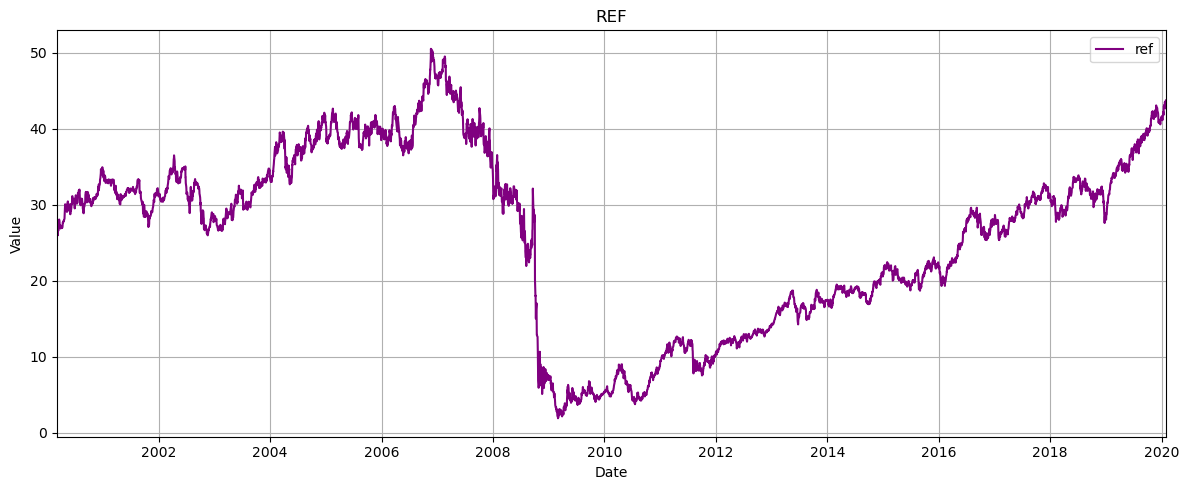

In [7]:
# Plot serie
plt.figure(figsize=(12, 5))                                      

plt.plot(ref.index, ref['close'], label='ref', color= 'purple')     

plt.title('REF')                      
plt.xlabel('Date')                                        
plt.ylabel('Value')  
plt.xlim(pd.to_datetime('2000-03-06'), pd.to_datetime('2020-01-31'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [8]:
# Resample by month and calculate the average of 'close'
mavg = ref.resample('M').mean().round(2)

# Show the result
mavg.head()

,close
date,
2000-03-31,27.04
2000-04-30,27.83
2000-05-31,29.72
2000-06-30,30.16
2000-07-31,30.94


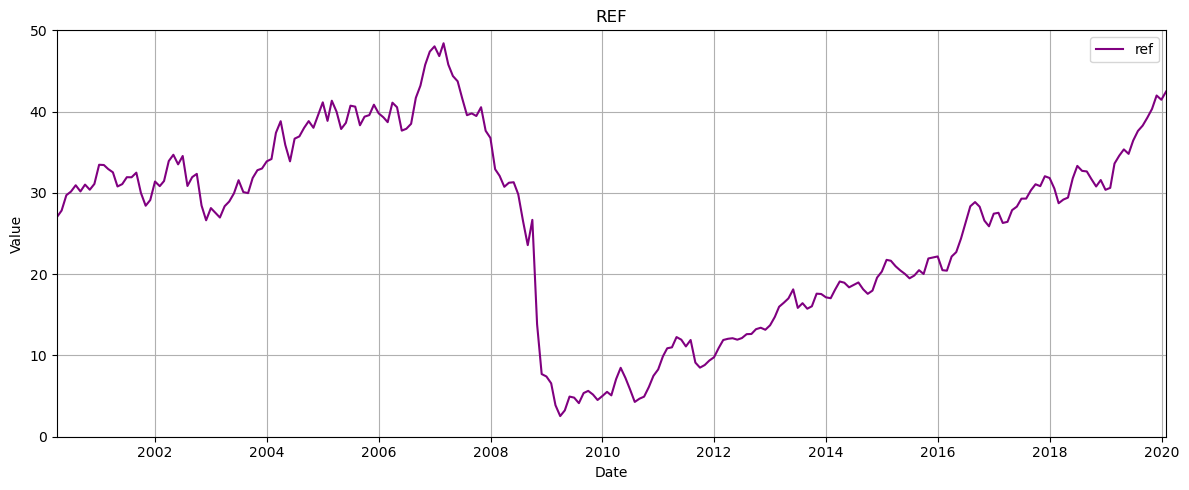

In [9]:
# Plot serie
plt.figure(figsize=(12, 5))                                      

plt.plot(mavg.index, mavg['close'], label='ref', color='purple')   

plt.title('REF')                      
plt.xlabel('Date')                                        
plt.ylabel('Value')  
plt.xlim(pd.to_datetime('2000-03-31'), pd.to_datetime('2020-01-31'))
plt.ylim(0,50)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

# SARIMA

In [10]:
# Split the data
cutoff = pd.to_datetime("2018-01-01")

train = mavg[mavg.index < cutoff]
test = mavg[mavg.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (214, 1)
Test shape: (25, 1)

            close
date             
2017-08-31  30.32
2017-09-30  31.06
2017-10-31  30.83
2017-11-30  32.05
2017-12-31  31.83

            close
date             
2018-01-31  30.54
2018-02-28  28.73
2018-03-31  29.18
2018-04-30  29.42
2018-05-31  31.78


In [11]:
ref_series = train['close']

In [12]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(ref_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.7971, p-value = 0.3819
d = 1 | ADF Statistic = -3.5583, p-value = 0.0066

Non-seasonal differencing term (d): 1


In [13]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(ref_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


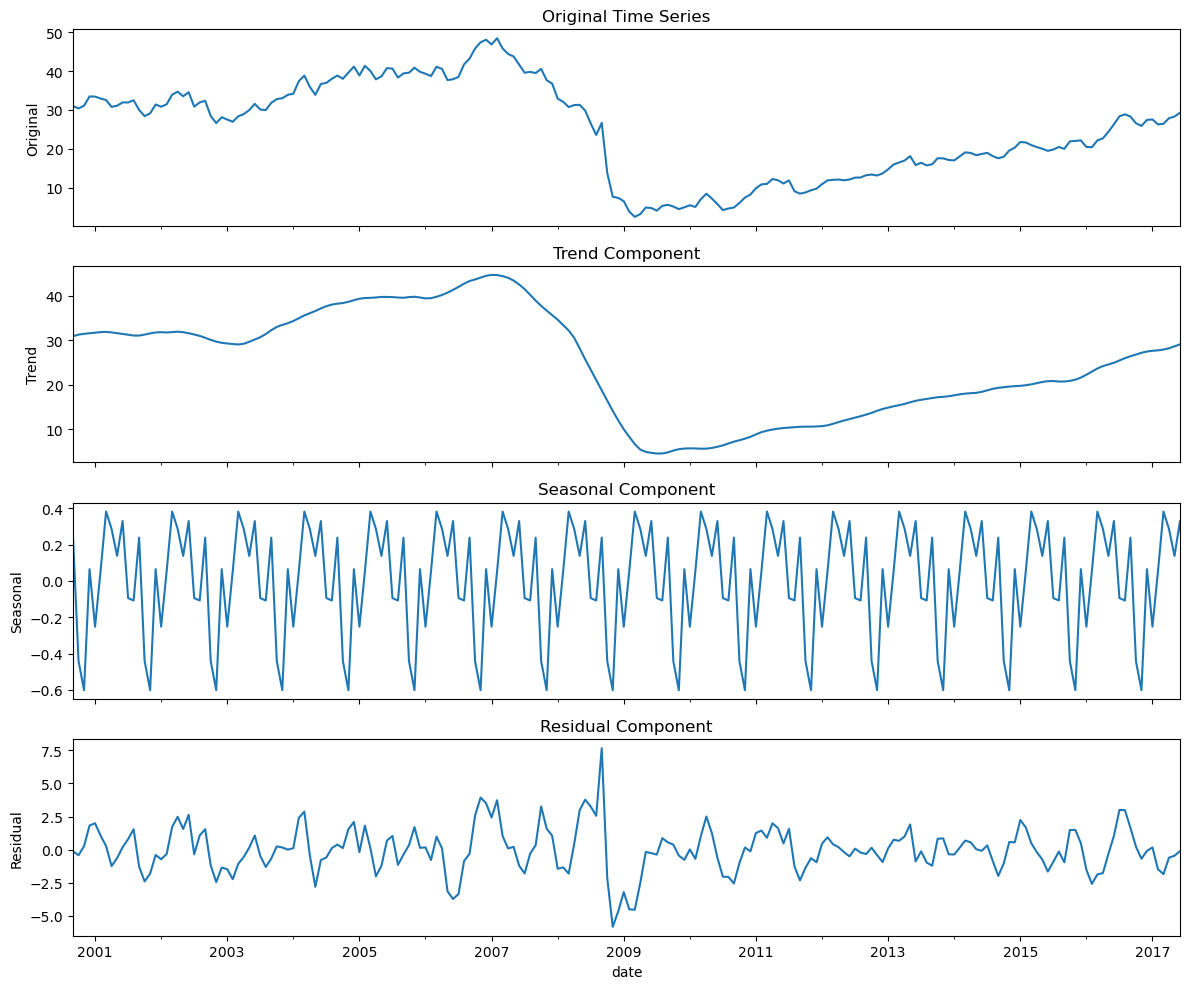

In [14]:
result = seasonal_decompose(ref_series, model='aditive', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [15]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    ref_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(2, 1, 3)(0, 0, 0, 12)


In [16]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]       # Define search ranges for non-seasonal parameters (p, q)
P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]         # Define search ranges for seasonal parameters (P, Q)
d = 1
D = 0
S = 12

total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(ref_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,model
0,251,"(3, 1, 3)","(2, 0, 3)",662.380233,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,255,"(3, 1, 3)","(3, 0, 3)",664.514981,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,187,"(2, 1, 3)","(2, 0, 3)",665.883512,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,238,"(3, 1, 2)","(3, 0, 2)",667.213776,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,191,"(2, 1, 3)","(3, 0, 3)",667.311746,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


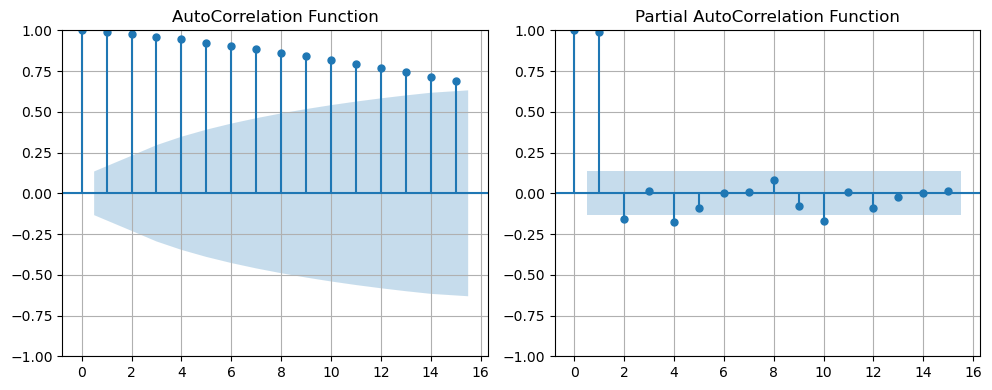

In [17]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Plot AutoCorrelation Function
plot_acf(ref_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Plot Partial Autocorrelation Function
plot_pacf(ref_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_313 = SARIMAX(ref_series,                      # Time series data
                    order=(3, 1, 3),                 # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 3, 12),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)      # Allow non-stationary behavior

# Fit the model
model_fit_313 = model_313.fit()

# Display summary of the model
print(model_fit_313.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                  214
Model:             SARIMAX(3, 1, 3)x(2, 0, 3, 12)   Log Likelihood                -319.190
Date:                            Wed, 07 May 2025   AIC                            662.380
Time:                                    09:59:06   BIC                            700.220
Sample:                                03-31-2000   HQIC                           677.731
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2388      0.279      4.448      0.000       0.693       1.785
ar.L2         -1.2590      0.205   

In [19]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_313)

ma.L3 coefficient: -0.3799
ma.L3 95% CI: (-0.9179, 0.1580)
ma.L3 p-value: 0.1663
ma.L3 is statistically IRRELEVANT in the model.

ar.S.L12 coefficient: -0.1312
ar.S.L12 95% CI: (-0.3481, 0.0856)
ar.S.L12 p-value: 0.2356
ar.S.L12 is statistically IRRELEVANT in the model.

ma.S.L12 coefficient: 0.2075
ma.S.L12 95% CI: (-3.3301, 3.7450)
ma.S.L12 p-value: 0.9085
ma.S.L12 is statistically IRRELEVANT in the model.

ma.S.L24 coefficient: -0.9706
ma.S.L24 95% CI: (-4.5363, 2.5952)
ma.S.L24 p-value: 0.5937
ma.S.L24 is statistically IRRELEVANT in the model.

ma.S.L36 coefficient: -0.2017
ma.S.L36 95% CI: (-0.9352, 0.5318)
ma.S.L36 p-value: 0.5899
ma.S.L36 is statistically IRRELEVANT in the model.



In [20]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_312 = SARIMAX(ref_series,                      # Time series data
                    order=(3, 1, 2),                 # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 0, 12),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)      # Allow non-stationary behavior

# Fit the model
model_fit_312 = model_312.fit()

# Display summary of the model
print(model_fit_312.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                  214
Model:             SARIMAX(3, 1, 2)x(1, 0, [], 12)   Log Likelihood                -376.472
Date:                             Wed, 07 May 2025   AIC                            766.944
Time:                                     09:59:06   BIC                            789.962
Sample:                                 03-31-2000   HQIC                           776.261
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9219      0.139      6.655      0.000       0.650       1.193
ar.L2         -0.8492      

In [21]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_312)

ar.S.L12 coefficient: 0.0030
ar.S.L12 95% CI: (-0.1477, 0.1538)
ar.S.L12 p-value: 0.9685
ar.S.L12 is statistically IRRELEVANT in the model.



In [22]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_3120 = SARIMAX(ref_series,                     # Time series data
                    order=(3, 1, 2),                 # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 12),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)      # Allow non-stationary behavior

# Fit the model
model_fit_3120 = model_3120.fit()

# Display summary of the model
print(model_fit_3120.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  214
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -397.975
Date:                Wed, 07 May 2025   AIC                            807.950
Time:                        09:59:06   BIC                            828.032
Sample:                    03-31-2000   HQIC                           816.068
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9486      0.107      8.877      0.000       0.739       1.158
ar.L2         -0.9024      0.126     -7.163      0.000      -1.149      -0.656
ar.L3          0.2513      0.057      4.385      0.0

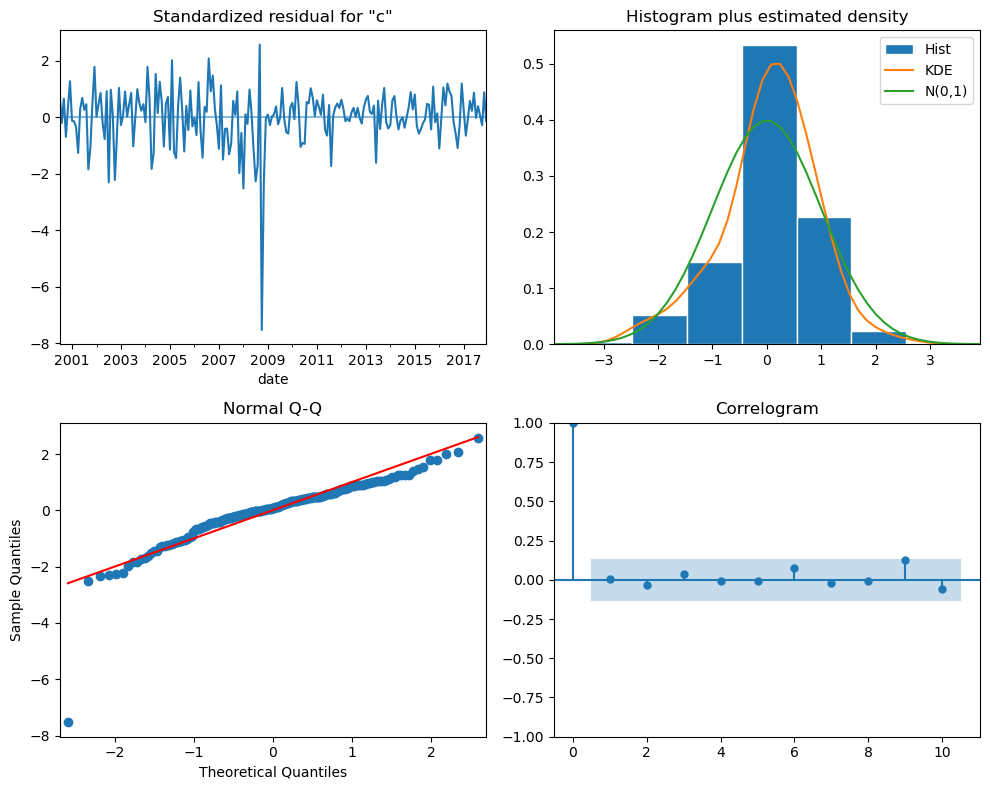

In [23]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_3120.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [24]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_3120.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,20.726646,5.297370e-06
2,28.997462,5.049882e-07
3,29.570738,1.698917e-06
4,29.979881,4.940812e-06
5,30.132409,1.388938e-05
6,30.902694,2.645696e-05
7,30.992337,6.237656e-05
8,31.018206,1.394589e-04
9,32.556146,1.595162e-04
10,32.667063,3.097831e-04


In [25]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.1360
Conclusion: No significant autocorrelation.


In [26]:
# Forecast the next 12 time points
forecast_S = model_fit_3120.get_forecast(steps=25)

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                                # Forecast mean

test['Error'] = test['Forecast S'] - test['close']

test['Lower 95% CI'] = conf_int_S.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_S.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,close,Forecast S,Error,Lower 95% CI,Upper 95% CI
date,,,,,
2018-01-31,30.54,31.808693,1.268693,28.671720,34.945666
2018-02-28,28.73,32.102890,3.372890,27.390311,36.815468
2018-03-31,29.18,32.345927,3.165927,26.404827,38.287026
2018-04-30,29.42,32.305633,2.885633,25.053462,39.557803
2018-05-31,31.78,32.122004,0.342004,23.492645,40.751364
2018-06-30,33.32,32.045236,-1.274764,22.216645,41.873827
2018-07-31,32.71,32.127999,-0.582001,21.359373,42.896624
2018-08-31,32.64,32.229650,-0.410350,20.665125,43.794176
2018-09-30,31.70,32.232104,0.532104,19.885910,44.578297


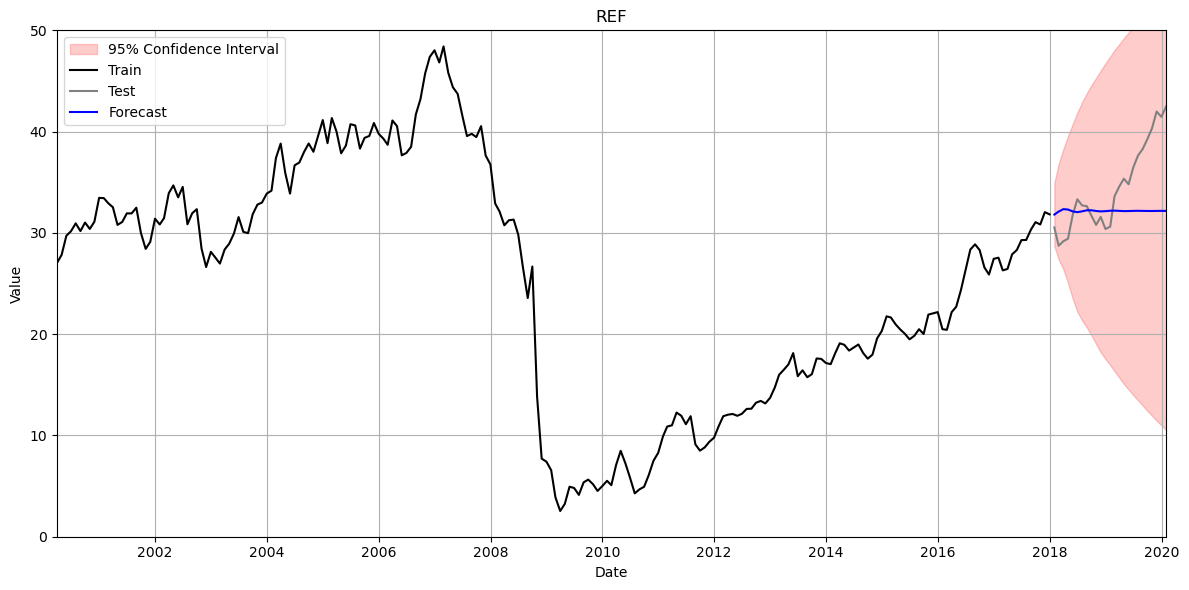

In [27]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['close'], label='Train', color='black')       # Train
plt.plot(test.index, test['close'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')    # Forecast

plt.title('REF')                      
plt.xlabel('Date')                                        
plt.ylabel('Value')  
plt.xlim(pd.to_datetime('2000-03-31'), pd.to_datetime('2020-01-31'))
plt.ylim(0,50)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX

In [28]:
mavg.head()

,close
date,
2000-03-31,27.04
2000-04-30,27.83
2000-05-31,29.72
2000-06-30,30.16
2000-07-31,30.94


In [29]:
url2 = ('https://raw.githubusercontent.com/andrewcole33/reit_time_series_analysis/refs/heads/master/data/FR_rates.csv')

# REF series
rates = pd.read_csv(url2)

rates.head()

,date,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
0,2000-03-01,26.998250,6.05,8.24,7.83,6.03,6.00,5.94,7.68,8.37,...,3521.57,1510.16,107.31,5685.93,5198.06,1024.58,64.99,46.42,0.90,0.19
1,2000-04-01,27.723158,6.15,8.15,7.80,6.15,6.11,6.03,7.64,8.40,...,3584.93,1531.49,110.75,5747.53,5262.45,1033.44,59.76,88.46,1.04,0.65
2,2000-05-01,29.697273,6.54,8.51,8.18,6.57,6.54,6.41,7.99,8.90,...,3563.07,1559.57,113.35,5821.97,5336.37,1051.14,77.52,55.96,0.63,0.30
3,2000-06-01,30.174318,6.65,8.29,7.99,6.59,6.57,6.53,7.67,8.48,...,3581.19,1578.90,114.16,5841.58,5345.38,1062.59,67.24,74.91,0.52,0.46
4,2000-07-01,30.854000,6.63,8.15,7.86,6.53,6.52,6.50,7.65,8.35,...,3607.03,1596.80,118.27,5861.82,5360.64,1068.18,53.87,45.33,0.55,0.37


In [30]:
# Make column 'Date' Index
rates['date'] = pd.to_datetime(rates['date'])
rates = rates.set_index(['date'])

rates.head()

,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,dff,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,26.998250,6.05,8.24,7.83,6.03,6.00,5.94,7.68,8.37,5.85,...,3521.57,1510.16,107.31,5685.93,5198.06,1024.58,64.99,46.42,0.90,0.19
2000-04-01,27.723158,6.15,8.15,7.80,6.15,6.11,6.03,7.64,8.40,6.02,...,3584.93,1531.49,110.75,5747.53,5262.45,1033.44,59.76,88.46,1.04,0.65
2000-05-01,29.697273,6.54,8.51,8.18,6.57,6.54,6.41,7.99,8.90,6.27,...,3563.07,1559.57,113.35,5821.97,5336.37,1051.14,77.52,55.96,0.63,0.30
2000-06-01,30.174318,6.65,8.29,7.99,6.59,6.57,6.53,7.67,8.48,6.53,...,3581.19,1578.90,114.16,5841.58,5345.38,1062.59,67.24,74.91,0.52,0.46
2000-07-01,30.854000,6.63,8.15,7.86,6.53,6.52,6.50,7.65,8.35,6.54,...,3607.03,1596.80,118.27,5861.82,5360.64,1068.18,53.87,45.33,0.55,0.37


In [31]:
# Shift the index of 'rates' to the end of the month
rates.index = rates.index + pd.offsets.MonthEnd(0)

rates.head(3)

,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,dff,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
date,,,,,,,,,,,,,,,,,,,,,
2000-03-31,26.998250,6.05,8.24,7.83,6.03,6.00,5.94,7.68,8.37,5.85,...,3521.57,1510.16,107.31,5685.93,5198.06,1024.58,64.99,46.42,0.90,0.19
2000-04-30,27.723158,6.15,8.15,7.80,6.15,6.11,6.03,7.64,8.40,6.02,...,3584.93,1531.49,110.75,5747.53,5262.45,1033.44,59.76,88.46,1.04,0.65
2000-05-31,29.697273,6.54,8.51,8.18,6.57,6.54,6.41,7.99,8.90,6.27,...,3563.07,1559.57,113.35,5821.97,5336.37,1051.14,77.52,55.96,0.63,0.30


In [32]:
merged = mavg.merge(rates, how='left', left_index=True, right_index=True)

merged.head()

,close,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
date,,,,,,,,,,,,,,,,,,,,,
2000-03-31,27.04,26.998250,6.05,8.24,7.83,6.03,6.00,5.94,7.68,8.37,...,3521.57,1510.16,107.31,5685.93,5198.06,1024.58,64.99,46.42,0.90,0.19
2000-04-30,27.83,27.723158,6.15,8.15,7.80,6.15,6.11,6.03,7.64,8.40,...,3584.93,1531.49,110.75,5747.53,5262.45,1033.44,59.76,88.46,1.04,0.65
2000-05-31,29.72,29.697273,6.54,8.51,8.18,6.57,6.54,6.41,7.99,8.90,...,3563.07,1559.57,113.35,5821.97,5336.37,1051.14,77.52,55.96,0.63,0.30
2000-06-30,30.16,30.174318,6.65,8.29,7.99,6.59,6.57,6.53,7.67,8.48,...,3581.19,1578.90,114.16,5841.58,5345.38,1062.59,67.24,74.91,0.52,0.46
2000-07-31,30.94,30.854000,6.63,8.15,7.86,6.53,6.52,6.50,7.65,8.35,...,3607.03,1596.80,118.27,5861.82,5360.64,1068.18,53.87,45.33,0.55,0.37


In [33]:
# Split the data
cutoff = pd.to_datetime("2018-01-01")

train2 = merged[merged.index < cutoff]
test2 = merged[merged.index >= cutoff]

# Show results
print("Train shape:", train2.shape)
print("Test shape:", test2.shape)
print()
print(train2.tail())
print()
print(test2.head())

Train shape: (214, 54)
Test shape: (25, 54)

            close        mid  usd1mtd156n  mortgage30us  mortgage15us  dcpf3m  \
date                                                                            
2017-08-31  30.32  30.300652         1.23          3.88          3.16    1.25   
2017-09-30  31.06  31.084125         1.23          3.80          3.10    1.25   
2017-10-31  30.83  30.798752         1.24          3.90          3.20    1.26   
2017-11-30  32.05  32.012262         1.29          3.92          3.29    1.32   
2017-12-31  31.83  31.872875         1.49          3.95          3.38    1.54   

            cpn3m  dcpf1m   aaa   baa  ...  dpsacbw027nbog  relacbw027nbog  \
date                                   ...                                   
2017-08-31   1.18    1.16  3.63  4.31  ...        11819.52         4234.87   
2017-09-30   1.18    1.17  3.63  4.30  ...        11862.73         4237.56   
2017-10-31   1.21    1.16  3.60  4.32  ...        11924.30         4263.19 

In [34]:
# Compute correlation matrix
corrs = train2.corr()

# Identify columns where the correlation with the first row is >= 0.7 or <= -0.7
relevant_columns = corrs.columns[(corrs.iloc[0] >= 0.7) | (corrs.iloc[0] <= -0.7)]

# Select only the relevant columns from the original DataFrame
matrix = train2[relevant_columns]
matrix

,close,mid,usd1mtd156n,dcpf3m,cpn3m,dcpf1m,dff,flexsc,mprime,tb3ms,dtb6,dgs3mo,dexchus
date,,,,,,,,,,,,,
2000-03-31,27.04,26.998250,6.05,6.03,6.00,5.94,5.85,5.93,8.83,5.69,5.85,5.86,8.28
2000-04-30,27.83,27.723158,6.15,6.15,6.11,6.03,6.02,6.15,9.00,5.66,5.81,5.82,8.28
2000-05-31,29.72,29.697273,6.54,6.57,6.54,6.41,6.27,6.30,9.24,5.79,6.10,5.99,8.28
2000-06-30,30.16,30.174318,6.65,6.59,6.57,6.53,6.53,6.62,9.50,5.69,5.97,5.86,8.28
2000-07-31,30.94,30.854000,6.63,6.53,6.52,6.50,6.54,6.62,9.50,5.96,6.00,6.14,8.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,30.32,30.300652,1.23,1.25,1.18,1.16,1.16,1.20,4.25,1.01,1.11,1.03,6.67
2017-09-30,31.06,31.084125,1.23,1.25,1.18,1.17,1.15,1.23,4.25,1.03,1.15,1.05,6.57
2017-10-31,30.83,30.798752,1.24,1.26,1.21,1.16,1.15,1.25,4.25,1.07,1.23,1.09,6.63


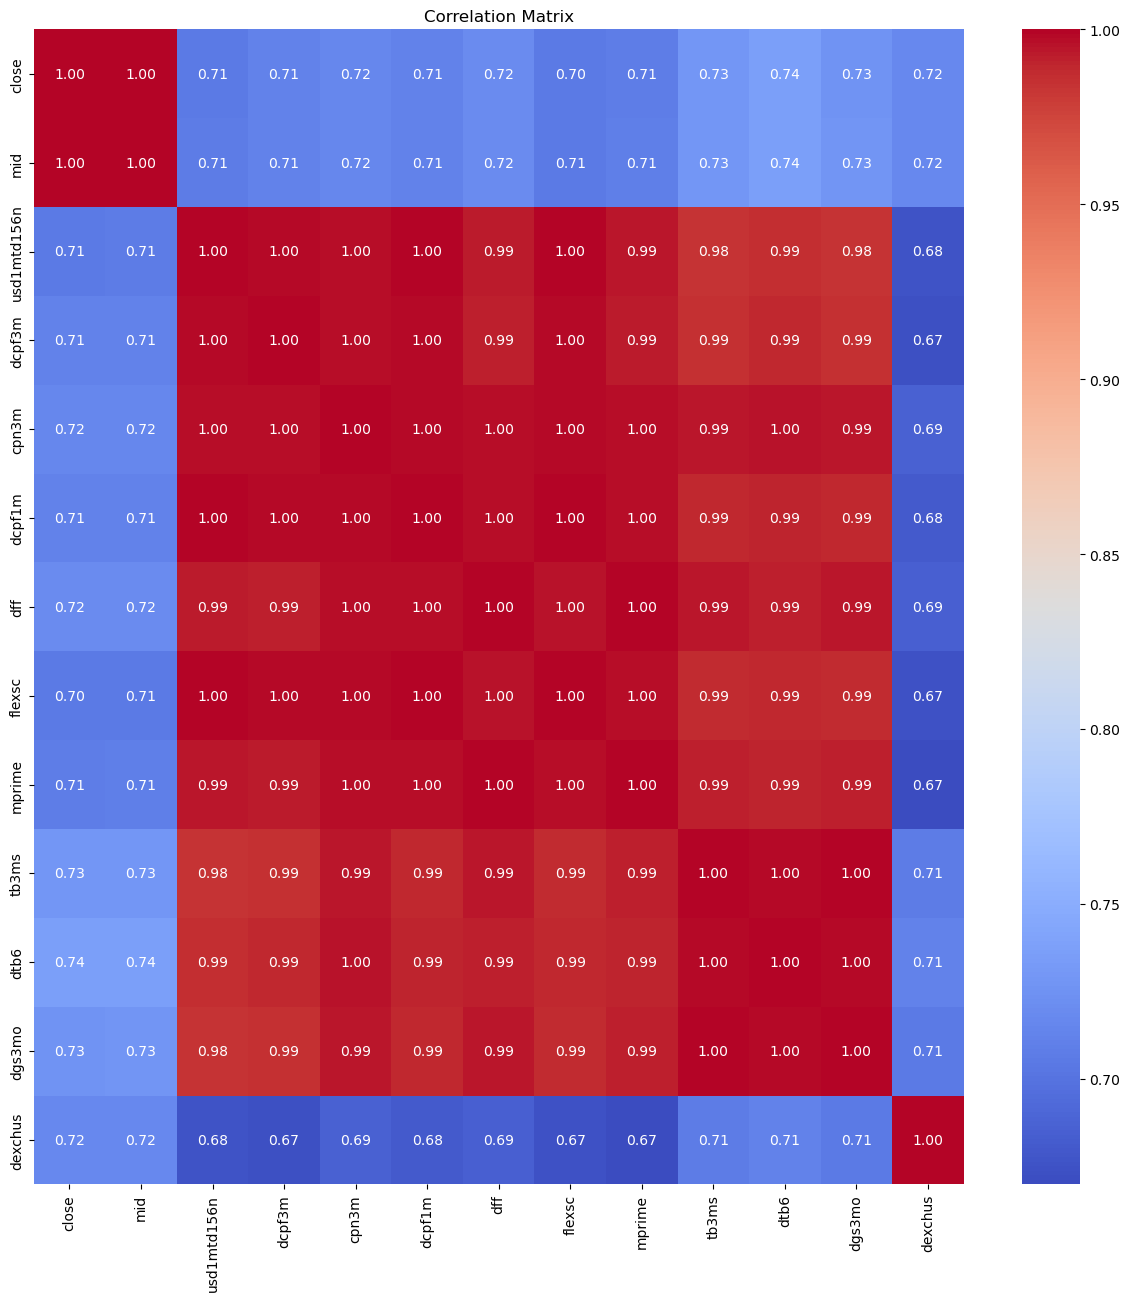

In [35]:
# Compute correlation matrix
correlation_matrix = matrix.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [36]:
matrix = matrix.drop(columns=['close'])
matrix

,mid,usd1mtd156n,dcpf3m,cpn3m,dcpf1m,dff,flexsc,mprime,tb3ms,dtb6,dgs3mo,dexchus
date,,,,,,,,,,,,
2000-03-31,26.998250,6.05,6.03,6.00,5.94,5.85,5.93,8.83,5.69,5.85,5.86,8.28
2000-04-30,27.723158,6.15,6.15,6.11,6.03,6.02,6.15,9.00,5.66,5.81,5.82,8.28
2000-05-31,29.697273,6.54,6.57,6.54,6.41,6.27,6.30,9.24,5.79,6.10,5.99,8.28
2000-06-30,30.174318,6.65,6.59,6.57,6.53,6.53,6.62,9.50,5.69,5.97,5.86,8.28
2000-07-31,30.854000,6.63,6.53,6.52,6.50,6.54,6.62,9.50,5.96,6.00,6.14,8.28
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,30.300652,1.23,1.25,1.18,1.16,1.16,1.20,4.25,1.01,1.11,1.03,6.67
2017-09-30,31.084125,1.23,1.25,1.18,1.17,1.15,1.23,4.25,1.03,1.15,1.05,6.57
2017-10-31,30.798752,1.24,1.26,1.21,1.16,1.15,1.25,4.25,1.07,1.23,1.09,6.63


In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = matrix.columns
vif_data["VIF"] = [round(variance_inflation_factor(matrix.values, i), 2) for i in range(len(matrix.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = matrix.corr().round(2)
print(f'Correlation:\n{corr}')

                   VIF          Interpretation
Feature                                       
mid              21.61  High Multicollinearity
usd1mtd156n    3753.50  High Multicollinearity
dcpf3m         1559.80  High Multicollinearity
cpn3m          1972.74  High Multicollinearity
dcpf1m         6810.97  High Multicollinearity
dff            1356.58  High Multicollinearity
flexsc         2705.75  High Multicollinearity
mprime          431.67  High Multicollinearity
tb3ms        176915.32  High Multicollinearity
dtb6           2255.42  High Multicollinearity
dgs3mo       170270.39  High Multicollinearity
dexchus         191.06  High Multicollinearity

Correlation:
              mid  usd1mtd156n  dcpf3m  cpn3m  dcpf1m   dff  flexsc  mprime  \
mid          1.00         0.71    0.71   0.72    0.71  0.72    0.71    0.71   
usd1mtd156n  0.71         1.00    1.00   1.00    1.00  0.99    1.00    0.99   
dcpf3m       0.71         1.00    1.00   1.00    1.00  0.99    1.00    0.99   
cpn3m       

#### Low VIF as a Proxy for Stability:

    A low VIF variable is less likely to be a proxy for other factors.

    It is more likely to capture an independent driver of our target variable.

Variable choosed to be exogenous series: **dexchus**

In [38]:
exog_data = train2[['dexchus']]  # Multiple column selection
endog_data = train2['close']     # Target variable selection

In [39]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(3, 1, 2),               
                    seasonal_order=(0, 0, 0, 12),    
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  214
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -397.003
Date:                Wed, 07 May 2025   AIC                            808.006
Time:                        09:59:07   BIC                            831.435
Sample:                    03-31-2000   HQIC                           817.477
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dexchus        4.6599      3.348      1.392      0.164      -1.901      11.221
ar.L1          0.9543      0.079     12.153      0.000       0.800       1.108
ar.L2         -0.9513      0.091    -10.434      0.0

In [40]:
# Identify exogenous variables: exclude AR, MA, seasonal terms, and sigma2
exo_vars = [name for name in model_fit_M.params.index 
            if name not in ['sigma2'] and not name.startswith(('ar.', 'ma.', 'ar.S.', 'ma.S.'))]

# Loop over each exogenous variable and evaluate its statistical relevance
for var in exo_vars:
    coef = model_fit_M.params[var]
    p_val = model_fit_M.pvalues[var]
    
    print(f"{var} coefficient: {coef:.4f}")
    print(f"{var} p-value: {p_val:.4f}")
    
    if abs(coef) < 0.1 and p_val > 0.05:
        print(f"{var} is statistically IRRELEVANT in the model.\n")
    else:
        print(f"{var} is statistically RELEVANT in the model.\n")

dexchus coefficient: 4.6599
dexchus p-value: 0.1639
dexchus is statistically RELEVANT in the model.



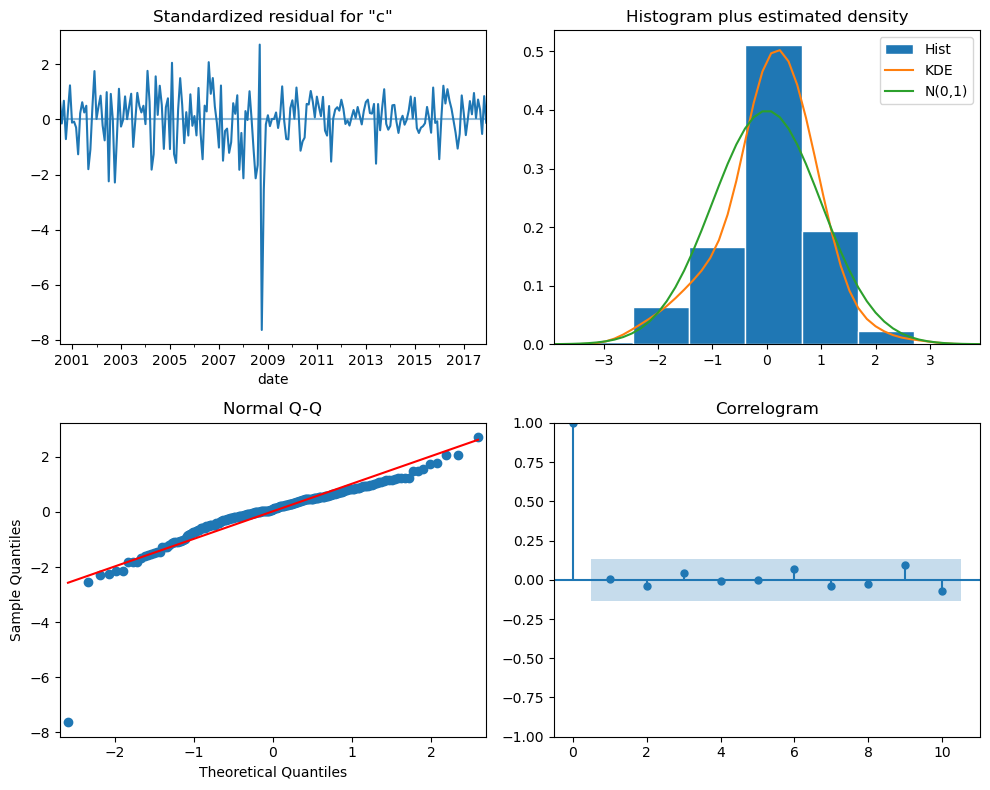

In [41]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [42]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,3.089501,0.078799
2,3.094235,0.212861
3,3.610145,0.306755
4,4.086104,0.394478
5,4.198080,0.521264
6,4.273360,0.639737
7,4.313038,0.743098
8,4.327132,0.826469
9,4.538336,0.872556
10,5.075738,0.886061


In [43]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.0520
Conclusion: No significant autocorrelation.


In [44]:
# Must match the structure of training exog
exog_test_M = test2[['dexchus']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=25, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test2['Forecast M'] = forecast_mean_M.values
test2['Error M'] = test2['Forecast M'] - test2['close']
test2['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test2['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test2.head()

,close,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,...,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,30.54,30.542738,1.56,4.03,3.48,1.63,1.59,1.48,3.55,4.26,...,14929.80,2106.48,114.80,29.12,3.00,0.11,30.981919,0.441919,27.865614,34.098223
2018-02-28,28.73,28.804739,1.60,4.33,3.78,1.78,1.69,1.51,3.82,4.51,...,14918.02,2109.34,84.04,37.82,5.89,0.16,30.676988,1.946988,26.017104,35.336871
2018-03-31,29.18,29.130119,1.80,4.44,3.91,2.08,1.90,1.72,3.87,4.64,...,14829.87,2120.26,76.38,18.01,2.95,0.10,30.864594,1.684594,24.981210,36.747978
2018-04-30,29.42,29.405362,1.90,4.47,3.92,2.20,2.00,1.82,3.85,4.67,...,14792.58,2169.71,88.60,33.05,2.70,0.12,30.783783,1.363783,23.595453,37.972114
2018-05-31,31.78,31.705568,1.95,4.59,4.07,2.16,2.03,1.82,4.00,4.83,...,14858.49,2176.67,87.87,24.92,2.93,0.12,30.982019,-0.797981,22.444183,39.519856


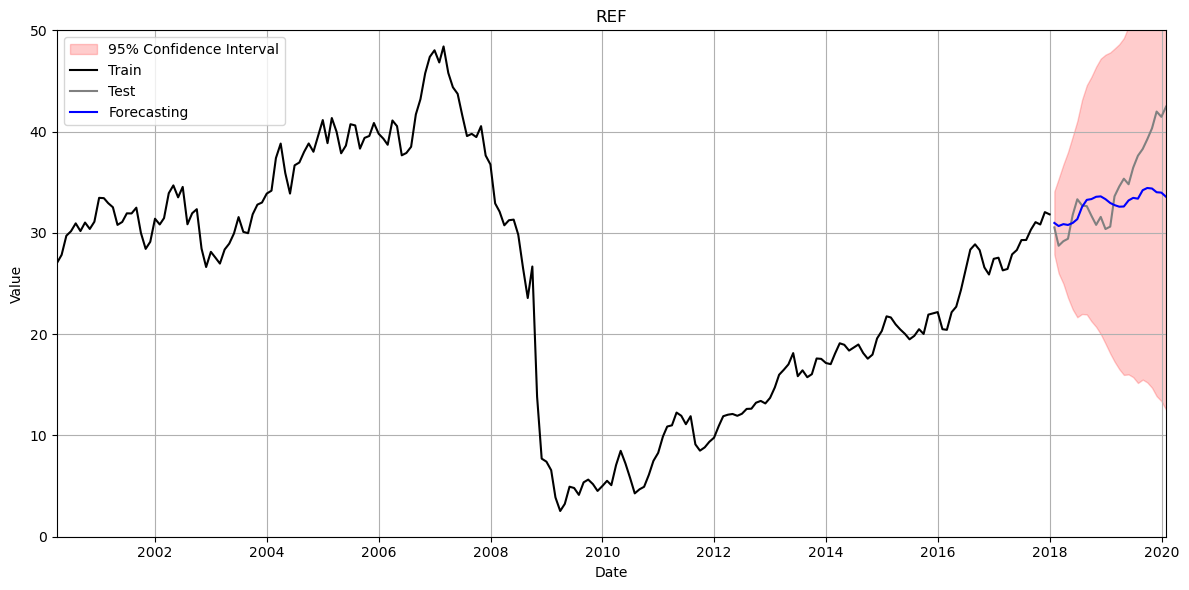

In [45]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train2.index, train2['close'], label='Train', color='black')                      
plt.plot(test2.index, test2['close'], label='Test', color='gray')     
plt.plot(test2.index, test2['Forecast M'], label='Forecasting', color='blue') 

plt.title('REF')                      
plt.xlabel('Date')                                        
plt.ylabel('Value')  
plt.xlim(pd.to_datetime('2000-03-31'), pd.to_datetime('2020-01-31'))
plt.ylim(0,50)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['close'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['close'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['close'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test2['close'], test2['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test2['close'], test2['Forecast M']))
mape_m = mean_absolute_percentage_error(test2['close'], test2['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

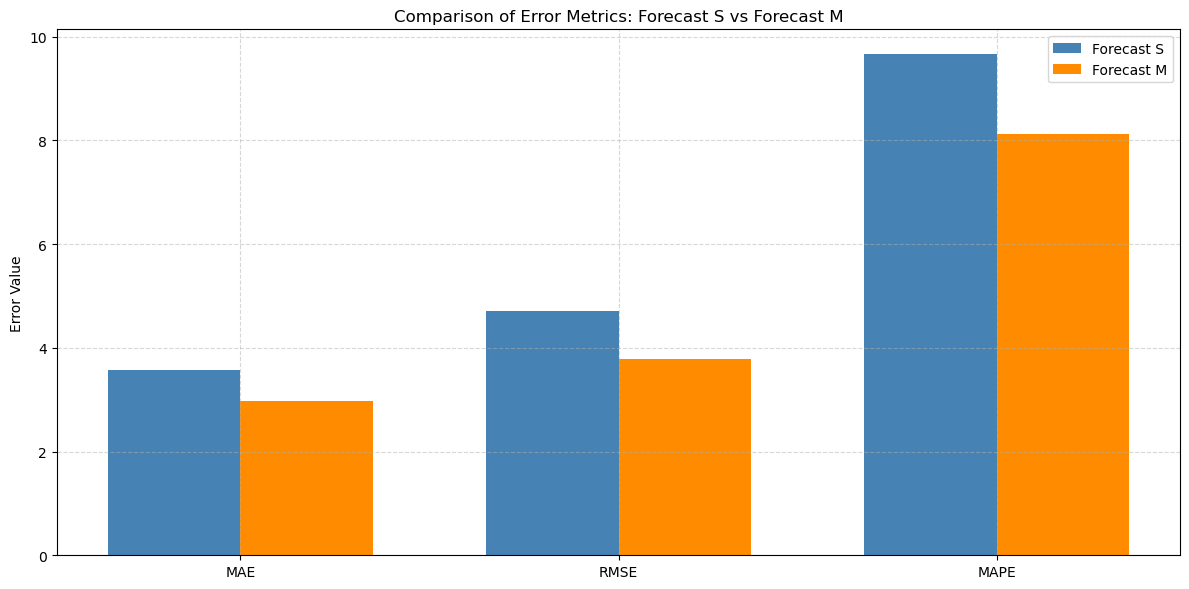

In [47]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [48]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,3.57,2.97
RMSE,4.72,3.78
MAPE,9.66,8.12


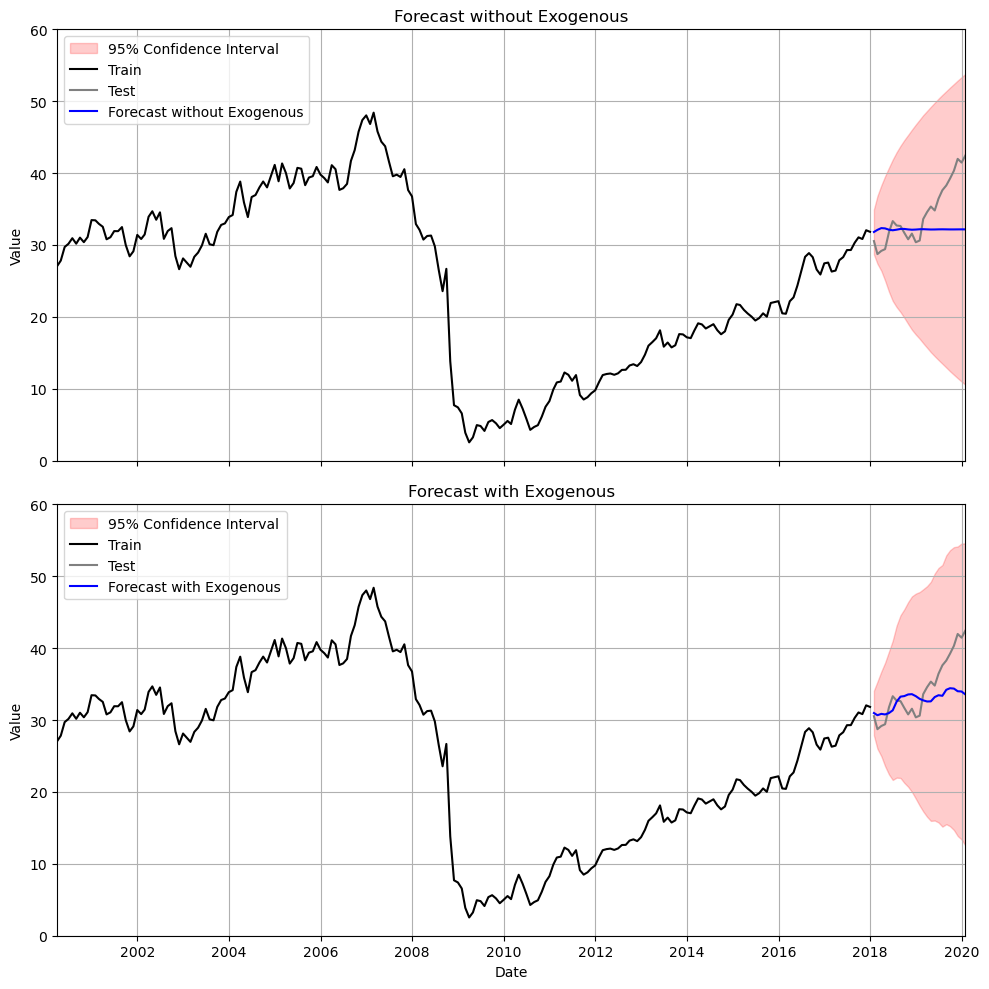

In [49]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast103) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['close'], label='Train', color='black')
axes[0].plot(test.index, test['close'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2000-03-31'), pd.to_datetime('2020-01-31'))
axes[0].set_ylim(0, 60)

# --- Second Forecast (ForecastM) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train2.index, train2['close'], label='Train', color='black')
axes[1].plot(test2.index, test2['close'], label='Test', color='gray')
axes[1].plot(test2.index, test2['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2000-03-31'), pd.to_datetime('2020-01-31'))
axes[1].set_ylim(0, 60)

# Final layout
plt.tight_layout()
plt.show()

End.

### Lasso Selection

The R-score of the Lasso Regression is: 0.6093
The RMSE of the Lasso Regression is: 7.3992



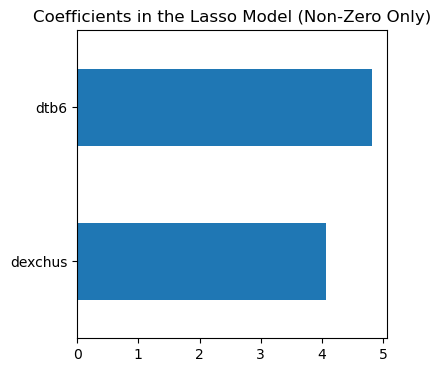


The best exogenous variable for forecasting, according to Lasso: dtb6


In [50]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


def choose_best_exogenous_variable(dataframe):
 
    target = dataframe['mid']                         # Set the target variable as 'mid'
    dataframe = dataframe.drop(['mid'], axis=1)       # Remove 'mid' from the independent variables

    # Standardize the data (important for Lasso)
    scaler = StandardScaler()                         # Initialize the scaler
    X_scaled = scaler.fit_transform(dataframe)        # Scale the features
    
    # Apply Lasso with Cross-Validation
    model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005], cv=5).fit(X_scaled, target)
    
    # Calculate the RMSE (Root Mean Squared Error)
    predictions = model_lasso.predict(X_scaled)                   # Generate predictions
    rmse = mean_squared_error(target, predictions, squared=False) # Compute RMSE
    
    # Display the Lasso model performance
    print(f"The R-score of the Lasso Regression is: {model_lasso.score(X_scaled, target):.4f}")
    print(f"The RMSE of the Lasso Regression is: {rmse:.4f}\n")
    
    # Extract coefficients for the exogenous variables
    coef = pd.Series(model_lasso.coef_, index=dataframe.columns)  # Store coefficients as a Series
    imp_coef = coef[coef != 0].sort_values()                      # Keep only non-zero coefficients
    
    # Check if any variable was selected by Lasso
    if imp_coef.empty:
        print("No variables were selected by Lasso. Please review your dataset.")
        return None
    
    # Plot the significant coefficients (non-zero)
    plt.figure(figsize=(4, 4))           
    imp_coef.plot(kind='barh')          
    plt.title("Coefficients in the Lasso Model (Non-Zero Only)")
    plt.show()
    
    # Identify the best exogenous variable (highest absolute coefficient)
    best_variable = imp_coef.abs().idxmax()  # Get the variable with the highest absolute value
    print(f"\nThe best exogenous variable for forecasting, according to Lasso: {best_variable}")
    
    return best_variable                     # Return the best variable


best_variable = choose_best_exogenous_variable(matrix)

Despite **dtb6** being chosen by Lasso (and having the highest correlation with the variable "close": 0.74), **dtb6** has a VIF of 2255.42, much higher than **dexchus** (VIF 191.06). The high multicollinearity can lead to unstable model coefficients, where small changes in the data can cause large changes in the model’s predictions.

The same calculation was done using **dtb6** instead of **dexchus** and the result was worse than the prediction without the use of exogenous variables.